In [8]:
import sys
sys.path.insert(0,'..')
import pandas as pd
import numpy as np
from optimizer.optimizer import Optimizer
from os import environ


# Set environment variable
environ["ENV"] = "optimize"

from bot.bot import SigBot
from config.config import ConfigFactory

# Get configs
configs = ConfigFactory.factory(environ).configs


pd.set_option('display.max_columns', 500)

ttype = 'sell'
pattern = ['STOCH', 'RSI']
# pattern = ['PriceChange']

stat = pd.read_pickle(f'../optimizer/opt_{"_".join(pattern)}_{ttype}.pkl')
stat['pct_right_forecast_avg'] = stat[[f'pct_right_forecast_{lag + 1}' for lag in range(24)]].apply(np.mean, axis=1)
stat = stat.sort_values(['pct_right_forecast_avg', 'forecasts_num'], ascending=False)
stat[stat['forecasts_num'] >= 5].head(20)

,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,pct_right_forecast_1,pct_right_forecast_2,pct_right_forecast_3,pct_right_forecast_4,pct_right_forecast_5,pct_right_forecast_6,pct_right_forecast_7,pct_right_forecast_8,pct_right_forecast_9,pct_right_forecast_10,pct_right_forecast_11,pct_right_forecast_12,pct_right_forecast_13,pct_right_forecast_14,pct_right_forecast_15,pct_right_forecast_16,pct_right_forecast_17,pct_right_forecast_18,pct_right_forecast_19,pct_right_forecast_20,pct_right_forecast_21,pct_right_forecast_22,pct_right_forecast_23,pct_right_forecast_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num,pct_right_forecast_avg
83,STOCH_RSI,12,30,5,2,3,20,100.0,66.67,66.67,50.0,66.67,50.0,50.0,83.33,83.33,83.33,66.67,83.33,83.33,83.33,83.33,83.33,83.33,83.33,83.33,83.33,83.33,83.33,83.33,83.33,-0.33,-0.22,-0.28,0.03,-0.12,0.12,-0.14,-0.45,-0.6,-0.73,-0.69,-0.78,-0.93,-1.25,-1.46,-1.76,-1.80,-2.42,-2.74,-2.20,-2.43,-2.14,-1.93,-1.95,6,77.081667
92,STOCH_RSI,12,30,5,3,3,20,100.0,75.00,75.00,37.5,37.50,25.0,62.5,75.00,75.00,75.00,62.50,87.50,87.50,87.50,87.50,87.50,75.00,87.50,75.00,75.00,75.00,75.00,75.00,75.00,-0.39,-0.47,-0.59,0.13,0.26,0.22,-0.16,-0.49,-1.0,-0.97,-1.03,-1.28,-2.78,-2.42,-2.28,-1.57,-1.57,-2.45,-2.32,-2.26,-2.28,-1.91,-1.68,-2.15,8,72.916667


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

buy_stat = pd.read_pickle('../signal_stat/buy_stat.pkl')
sell_stat = pd.read_pickle('../signal_stat/sell_stat.pkl')
buy_stat = buy_stat[buy_stat['time'].max() - buy_stat['time'] < pd.Timedelta(36, "h")]
sell_stat = sell_stat[sell_stat['time'].max() - sell_stat['time'] < pd.Timedelta(36, "h")]

# Create test dataframe

In [10]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from datetime import datetime
from os import environ
from data.get_data import GetData
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory
from signals.find_signal import SignalFactory

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)

debug = False
# Set environment variable
environ["ENV"] = "test"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}

# Get configs
configs = ConfigFactory.factory(environ).configs
       
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'API': GetData(**configs), 'tickers': ['CRVUSDT']}}

# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange, **configs)
    tickers = exchanges[exchange]['tickers']
    exchange_api.fill_ticker_dict(tickers)
    exchanges[exchange]['API'] = exchange_api

    # Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_data in exchanges.items():
    exchange_api = exchange_data['API']
    tickers = exchange_data['tickers']
    timeframes = ['1h', '5m']
    for ticker in tickers:
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle(f'test_{ticker}_{timeframe}.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, data_qty = exchange_api.get_data(df, ticker, timeframe)
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
            if data_qty > 1:
                indicators = list()
                if timeframe == work_timeframe:
                    indicator_list = configs['Indicator_list']
                else:
                    indicator_list = ['SUP_RES', 'LinearReg']
                for indicator in indicator_list:
                    ind_factory = IndicatorFactory.factory(indicator, configs)
                    if ind_factory:
                        indicators.append(ind_factory)
                # Write indicators to dataframe, update dataframe dict
                dfs, df = exchange_api.add_indicator_data(dfs, df, indicators, ticker, timeframe, data_qty, configs)
                # Get signals
                if timeframe == work_timeframe:
                    fs = FindSignal(configs)
                    levels = dfs[ticker][timeframe]['levels']
                    points = fs.find_signal(dfs, ticker, timeframe, data_qty)

Exchange is Binance, ticker is CRVUSDT, timeframe is 1h
Exchange is Binance, ticker is CRVUSDT, timeframe is 5m


# Test create_plot method of Vizualizer class

KeyError: 'LinearReg'

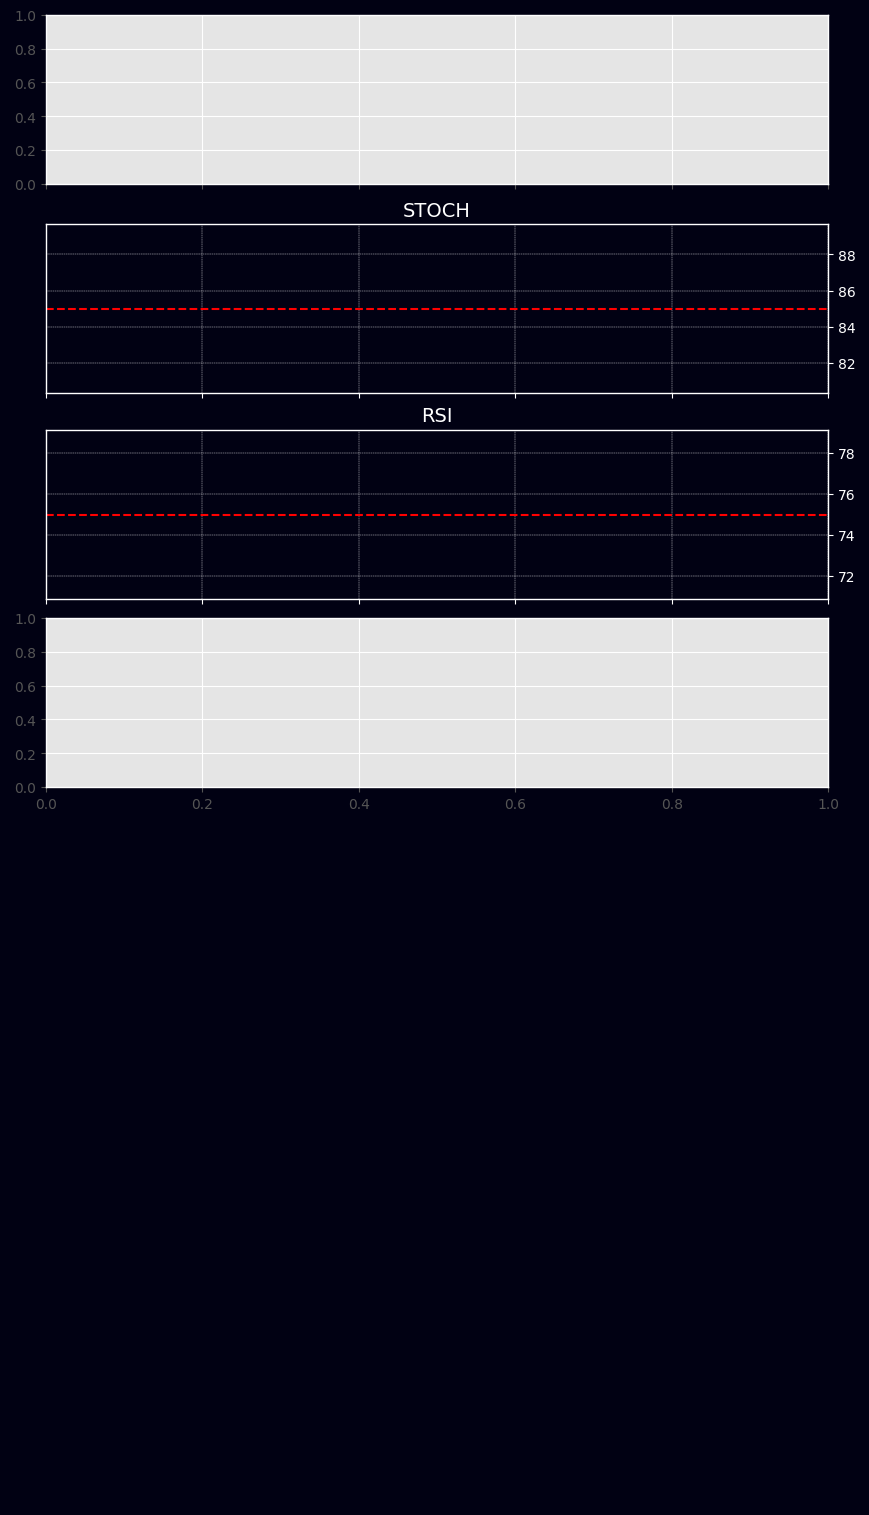

In [11]:
# class Visualizer:
#     type = 'Visualizer'
#     ticker_color = 'white'
#     border_color = 'white'
#     background_color = '#010113'
#     stat_color_1 = '#0ED6F1'
#     stat_std_color_1 = '#19E729'
#     stat_std_color_2 = '#E73B19'
#     stat_color_2 = '#EE4B1A'

#     def __init__(self, **params):
#         self.params = params[self.type]['params']
#         # Path to save plot files
#         self.image_path = self.params['image_path']
#         self.indicator_params = params['Indicator_signal']
#         self.plot_width = self.params.get('plot_width', 10)
#         self.indicator_dict = self.params.get('indicator_dict', dict())
#         self.level_indicators = self.params.get('level_indicators', list())
#         self.boundary_indicators = self.params.get('boundary_indicators', list())
#         # Max number of previous candles for which signal can be searched for
#         self.max_prev_candle_limit = self.params.get('max_prev_candle_limit', 0)
#         # dict for storing previous statistics values
#         self.prev_stat_dict = dict()

#     def plot_indicator_parameters(self, point_type: str, index: int, indicator: str,
#                                   axs: plt.axis, indicator_params: list) -> None:
#         """ Plot parameters of indicator (like low or high boundary, etc.)"""
#         indicator_param = indicator_params[index]
#         if indicator_param:
#             if indicator in self.boundary_indicators:
#                 if point_type == 'buy':
#                     axs[index + 1].axhline(y=indicator_param[0], color='g', linestyle='--', linewidth=1.5)
#                 else:
#                     axs[index + 1].axhline(y=indicator_param[1], color='r', linestyle='--', linewidth=1.5)

#     def plot_point(self, point_type: str, data: pd.DataFrame, ax: plt.axis, index=0) -> None:
#         """ Plot trade point """
#         if index > 0:
#             color = 'blue'
#         elif point_type == 'buy':
#             color = 'green'
#         else:
#             color = 'red'
#         if point_type == 'buy':
#             ax.scatter(self.plot_width-index, data['close'].iloc[-1-index], s=50, color=color)
#         else:
#             ax.scatter(self.plot_width-index, data['close'].iloc[-1-index], s=50, color=color)

#     @staticmethod
#     def plot_levels(data: pd.DataFrame, levels: list, axs: plt.axis) -> None:
#         """ Plot support and resistance levels"""
#         for level in levels:
#             if data['low'].min() <= level[0] <= data['high'].max():  # and level[1] == 3:
#                 axs[0].axhline(y=level[0], color='b', linestyle='dotted', linewidth=1.5)

#     def save_plot(self, ticker, timeframe, pattern, data):
#         filename = f"{self.image_path}/{ticker}_{timeframe}_{pattern}_{data['time'].iloc[-1]}.png"
#         plt.savefig(filename, bbox_inches='tight')
#         return filename

#     @staticmethod
#     def process_ticker(ticker: str) -> str:
#         """ Bring ticker to more convenient view """
#         if '-' in ticker:
#             return ticker
#         if '/' in ticker:
#             ticker = ticker.replace('/', '-')
#             return ticker
#         ticker = ticker[:-4] + '/' + ticker[-4:]
#         return ticker

#     @staticmethod
#     def statistics_change(prev_mean_right_prognosis, mean_right_prognosis):
#         """ Measure statistics difference between previous signal and current signal """
#         stat_diff = round(mean_right_prognosis - prev_mean_right_prognosis, 2)
#         if stat_diff < 0:
#             return f'= уменьшилась на {abs(stat_diff)}%'
#         if stat_diff > 0:
#             return f'= выросла на {stat_diff}%'
#         return '= без изменений'

#     def create_plot(self, dfs, point, levels):
#         # get necessary info
#         ticker, timeframe, point_index, point_type, time, pattern, plot_path, exchange_list, statistics, y = point
#         df = dfs[ticker][timeframe]['data']
#         data = df.loc[point_index - self.plot_width:point_index]
#         ohlc = data[['time', 'open', 'high', 'low', 'close', 'volume']]
#         # get indicator list
#         indicator_list = [p[0] for p in pattern if p[0] not in self.level_indicators]
#         indicator_params = [p[1] for p in pattern if p not in self.level_indicators]
#         plot_num = len(indicator_list) + 1

#         # Plot signal
#         # make subfigs
#         fig = plt.figure(constrained_layout=True, figsize=(1.7 * (plot_num + 1), 3 * (plot_num + 1)))
#         fig.patch.set_facecolor(self.background_color)
#         subfigs = fig.subfigures(2, 1, wspace=0, height_ratios=[3, 2.5])

#         # make subplots
#         axs1 = subfigs[0].subplots(plot_num, 1, sharex=True)
#         subfigs[0].patch.set_facecolor(self.background_color)
#         subfigs[1].patch.set_facecolor(self.background_color)
#         ap = list()

#         # plot candles
#         ohlc = ohlc.set_index('time')

#         for index, indicator in enumerate(indicator_list):
#             if indicator == 'PriceChange':
#                 self.plot_point(point_type, data, axs1[0], indicator_params[index])
#             # plot indicator
#             indicator_columns = self.indicator_dict[indicator]
#             for i_c in indicator_columns:
#                 m = mpf.make_addplot(data[i_c], panel=index + 1, title=indicator, ax=axs1[index + 1], width=2)
#                 ap.append(m)
#             # plot indicator parameters
#             self.plot_indicator_parameters(point_type, index, indicator, axs1, indicator_params)
#             # plot y-labels from right side
#             axs1[index + 1].yaxis.set_label_position("right")
#             axs1[index + 1].yaxis.tick_right()
#             # plot grid
#             axs1[index + 1].grid(which='both', linestyle='--', linewidth=0.3)
#             # set title
#             axs1[index + 1].set_title(indicator, fontsize=14, color=self.ticker_color)
#             # set ticker color
#             axs1[index + 1].tick_params(axis='x', colors=self.ticker_color)
#             axs1[index + 1].tick_params(axis='y', colors=self.ticker_color)
#             # set background color
#             axs1[index + 1].patch.set_facecolor(self.background_color)
#             # set border color
#             axs1[index + 1].spines['bottom'].set_color(self.border_color)
#             axs1[index + 1].spines['top'].set_color(self.border_color)
#             axs1[index + 1].spines['right'].set_color(self.border_color)
#             axs1[index + 1].spines['left'].set_color(self.border_color)

#         # plot candles
#         axs1[0].grid(which='both', linestyle='--', linewidth=0.3)
#         # set ticker color
#         axs1[0].tick_params(axis='x', colors=self.ticker_color)
#         axs1[0].tick_params(axis='y', colors=self.ticker_color)
#         # set background color
#         axs1[0].patch.set_facecolor(self.background_color)
#         # set border color
#         axs1[0].spines['bottom'].set_color(self.border_color)
#         axs1[0].spines['top'].set_color(self.border_color)
#         axs1[0].spines['right'].set_color(self.border_color)
#         axs1[0].spines['left'].set_color(self.border_color)

#         # set x-labels
#         # axs1[-1].set_xlabel(f"\n{data['time'].iloc[-1].date()}\n", fontsize=14)
#         plt.xticks(rotation=30)

#         # plot all subplots
#         mpf.plot(ohlc, type='candle', ax=axs1[0], addplot=ap, warn_too_much_data=1001, style='yahoo',
#                  ylabel='', returnfig=True)

#         # set titles
#         axs1[0].set_title(f'{self.process_ticker(ticker)} - {timeframe} - '
#                           f'{data["time"].iloc[-1].date().strftime("%d.%m.%Y")}', fontsize=14, color=self.ticker_color)
#         for index, indicator in enumerate(indicator_list):
#             axs1[index + 1].set_title(indicator, fontsize=14, color=self.ticker_color)

#         # plot point of trade
#         self.plot_point(point_type, data, axs1[0])

#         # plot levels
#         # self.plot_levels(data, levels, axs1)

#         # Plot signal statistics
#         pct_right_prognosis = [s[0] for s in statistics[0]]
#         pct_price_diff_mean = [s[1] for s in statistics[0]]
#         pct_price_diff_std = [s[2] for s in statistics[0]]
#         pct_price_diff_mean_plus_std = [a + b for a, b in zip(pct_price_diff_mean, pct_price_diff_std)]
#         pct_price_diff_mean_minus_std = [a - b for a, b in zip(pct_price_diff_mean, pct_price_diff_std)]

#         # get previous percent of right prognosis and save current percent to statistics dictionary
#         mean_right_prognosis = round(sum(pct_right_prognosis)/len(pct_right_prognosis), 2)
#         if str(pattern[0][0]).startswith('PriceChange'):
#             key = str(pattern[0][0])
#         else:
#             key = str(pattern)
#         # check if pattern and trade type are in statistics dictionary
#         if key in self.prev_stat_dict and self.prev_stat_dict[key] and point_type in self.prev_stat_dict[key]:
#             prev_mean_right_prognosis = self.prev_stat_dict[key][point_type]
#         else:
#             prev_mean_right_prognosis = mean_right_prognosis
#             self.prev_stat_dict[key] = dict()

#         self.prev_stat_dict[key][point_type] = mean_right_prognosis

#         # get change of statistics
#         stat_change = self.statistics_change(prev_mean_right_prognosis, mean_right_prognosis)

#         # make subplots
#         axs2 = subfigs[1].subplots(2, 1, sharex=True)

#         # make plots
#         axs2[0].plot(pct_right_prognosis, linewidth=2, color=self.stat_color_1)
#         axs2[0].yaxis.set_label_position("right")
#         axs2[0].yaxis.tick_right()
#         axs2[1].plot(pct_price_diff_mean_plus_std, linewidth=1.5, linestyle='--', color=self.stat_std_color_1)
#         axs2[1].plot(pct_price_diff_mean_minus_std, linewidth=1.5, linestyle='--', color=self.stat_std_color_2)
#         axs2[1].plot(pct_price_diff_mean, linewidth=2, color=self.stat_color_2)
#         axs2[1].yaxis.set_label_position("right")
#         axs2[1].yaxis.tick_right()
#         # plot grid
#         axs2[0].grid(which='both', linestyle='--', linewidth=0.3)
#         axs2[1].grid(which='both', linestyle='--', linewidth=0.3)

#         # set title
#         if point_type == 'buy':
#             title = '\nСTATИСТИКА СИГНАЛА НА ПОКУПКУ'
#         else:
#             title = '\nСTATИСТИКА СИГНАЛА НА ПРОДАЖУ'
#         axs2[0].set_title(f'{title}\n\nВероятность правильного движения цены после сигнала\n'
#                           f'(в среднем - {mean_right_prognosis}% {stat_change})',
#                           fontsize=13, color=self.ticker_color)
#         axs2[1].set_title('Средняя разница между текущей ценой актива\nи его ценой во время сигнала', fontsize=13,
#                           color=self.ticker_color)

#         # set x-ticks
#         xticklabels = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120']
#         # set ticker color
#         axs2[0].tick_params(axis='x', colors=self.ticker_color)
#         axs2[0].tick_params(axis='y', colors=self.ticker_color)
#         # set background color
#         axs2[0].patch.set_facecolor(self.background_color)
#         # set border color
#         axs2[0].spines['bottom'].set_color(self.border_color)
#         axs2[0].spines['top'].set_color(self.border_color)
#         axs2[0].spines['right'].set_color(self.border_color)
#         axs2[0].spines['left'].set_color(self.border_color)

#         axs2[1].set_xticks(np.arange(1, 25, 2))
#         axs2[1].set_xticklabels(xticklabels)
#         plt.xticks(rotation=30)

#         # set x-labels
#         axs2[1].set_xlabel(f"время после сигнала, в минутах", fontsize=12, color=self.ticker_color)

#         # set y-labels
#         axs2[0].set_ylabel("вероятность, %", fontsize=9.5, color=self.ticker_color)
#         axs2[1].set_ylabel("разница цен %", fontsize=9.5, color=self.ticker_color)

#         # set ticker color
#         axs2[1].tick_params(axis='x', colors=self.ticker_color)
#         axs2[1].tick_params(axis='y', colors=self.ticker_color)

#         # set background color
#         axs2[1].patch.set_facecolor(self.background_color)

#         # set border color
#         axs2[1].spines['bottom'].set_color(self.border_color)
#         axs2[1].spines['top'].set_color(self.border_color)
#         axs2[1].spines['right'].set_color(self.border_color)
#         axs2[1].spines['left'].set_color(self.border_color)

#         # save plot to file
# #         filename = self.save_plot(ticker, timeframe, pattern, data)

#         # close figure
# #         plt.close()

# #         return filename

# # matplotlib.use('NbAgg')
# v = Visualizer(**configs)
# # Plot signal statistics
# statistics = [[(100.0, -0.11, 2), (66.67, -0.09, 2.1), (33.33, 0.02, 2.07), (50.0, 0.1, 2.12), (50.0, 0.11, 2.16), 
#               (33.33, 0.15, 2.17), (33.33, 0.07, 2.2), (50.0, 0.01, 2.11), (50.0, -0.1, 2.1), (50.0, -0.29, 2.05), 
#               (66.67, -0.49, 2), (66.67, -0.71, 1.98), (66.67, -0.74, 1.91), (66.67, -0.71, 1.92), (66.67, -0.79, 1.95), 
#               (66.67, -0.89, 1.96), (83.33, -1.03, 2), (83.33, -1.08, 2.1), (83.33, -1.01, 2.18), (83.33, -0.98, 2.15), 
#               (100.0, -1.01, 2.2), (100.0, -0.99, 2.34), (100.0, -1.01, 2.28), (83.33, -1.04, 2.4)]]
# points[-2][-2] = statistics
# v.create_plot(dfs, points[-2], levels)
# plt.show()

# Test higher_bound and low_bound methods for RSI indicator

This methods return True if at least two of three last indicator points are higher/lower than high/low bound for this indicator.

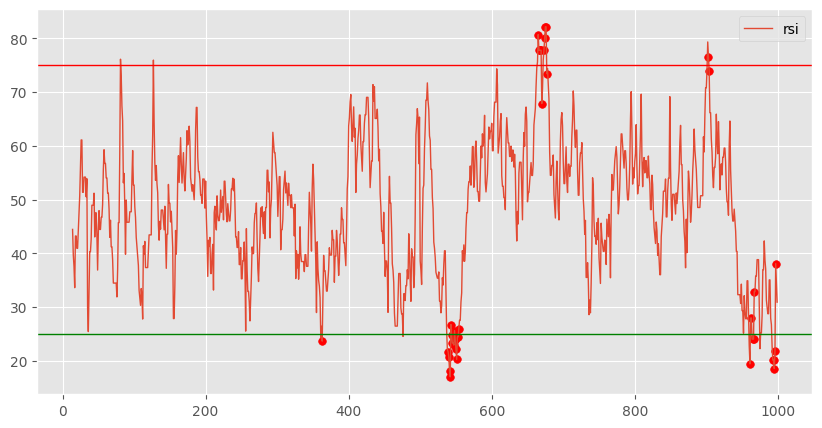

In [12]:
high_bound = 75
low_bound = 25

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot RSI
ax.plot(df.loc[:, 'rsi'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['rsi'])

# plot signal points
scatter_rsi_points = list()
rsi_sig = SignalFactory().factory('RSI', configs)

for index, row in df.iterrows():
    if index > 2:
        if rsi_sig.higher_bound(df['rsi'], index, high_bound) or rsi_sig.lower_bound(df['rsi'], index, low_bound):
            scatter_rsi_points.append((index, df.loc[index, 'rsi']))

for point in scatter_rsi_points:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test up_direction and down_direction methods for STOCH indicator

This methods return True if indicator values increase/decrease.

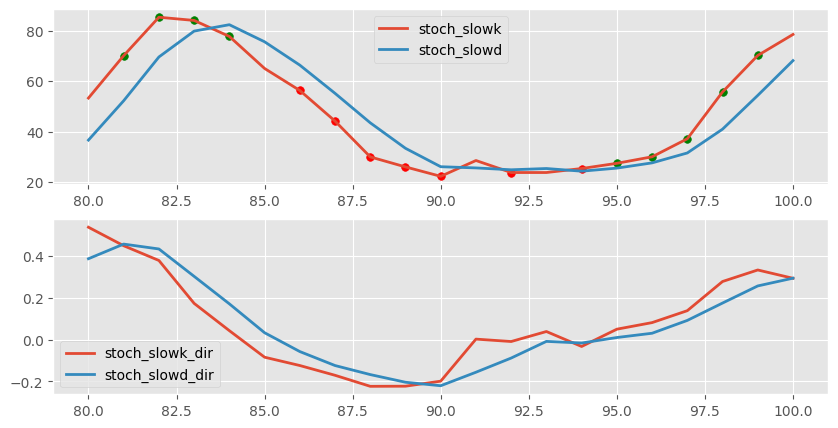

In [13]:
# subplots for STOCH
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot STOCH
ax1.plot(df.loc[80:100, 'stoch_slowk'], linewidth=2)
ax1.plot(df.loc[80:100, 'stoch_slowd'], linewidth=2)
ax2.plot(df.loc[80:100, 'stoch_slowk_dir'], linewidth=2)
ax2.plot(df.loc[80:100, 'stoch_slowd_dir'], linewidth=2)
leg = ax1.legend(['stoch_slowk', 'stoch_slowd'])
leg = ax2.legend(['stoch_slowk_dir', 'stoch_slowd_dir'])

# plot signal points
scatter_stoch_points_up = list()
scatter_stoch_points_down = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 80 < index < 100:
        if (stoch_sig.up_direction(df['stoch_slowk_dir'], index) and \
            stoch_sig.up_direction(df['stoch_slowd_dir'], index)):
            scatter_stoch_points_up.append((index, df.loc[index, 'stoch_slowk']))
        if (stoch_sig.down_direction(df['stoch_slowk_dir'], index) and \
            stoch_sig.down_direction(df['stoch_slowd_dir'], index)):
            scatter_stoch_points_down.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_up:
    ax1.scatter(point[0], point[1], s=30, color='green')

for point in scatter_stoch_points_down:
    ax1.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test crossed_lines method for STOCH indicator

This methods return True if two lines of indicator has crossed (for previous or pre-previous values).

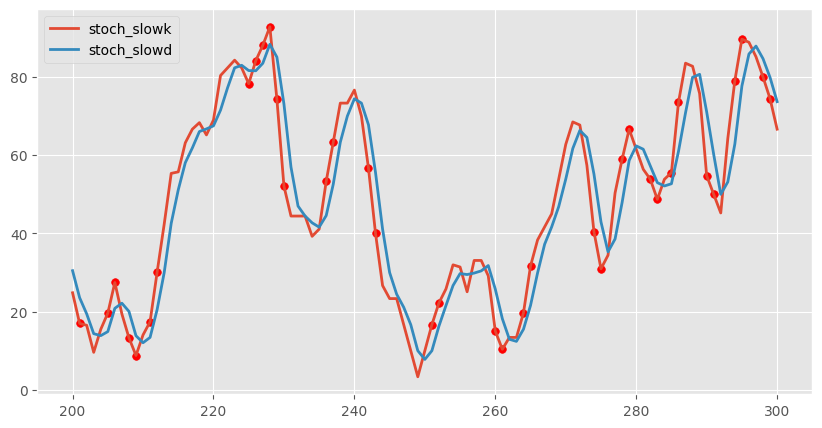

In [14]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
ax.plot(df.loc[200:300, 'stoch_slowk'], linewidth=2)
ax.plot(df.loc[200:300, 'stoch_slowd'], linewidth=2)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 200 < index < 300:
        if stoch_sig.crossed_lines(df['stoch_diff'], index, True) or \
           stoch_sig.crossed_lines(df['stoch_diff'], index, False):
            scatter_stoch_points.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for STOCH indicator

This methods return True if STOCH indicator is in overbuy/oversell zone, slowk and slowd lines has crossed and both changed their direction.

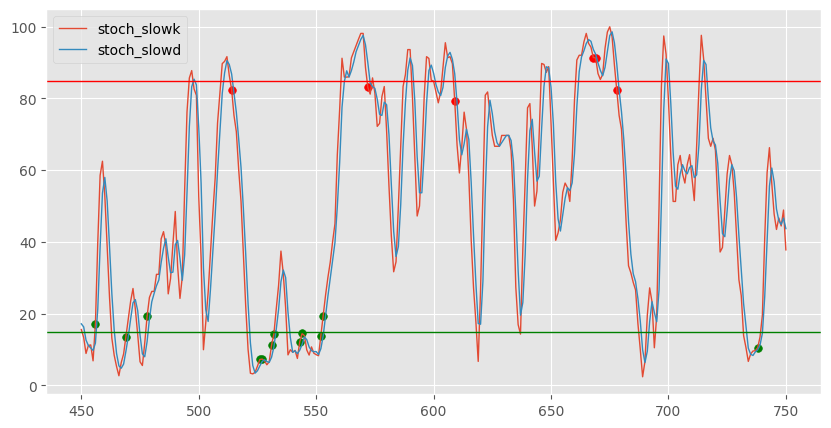

In [15]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
high_bound = 85
low_bound = 15
ax.plot(df.loc[450:750, 'stoch_slowk'], linewidth=1)
ax.plot(df.loc[450:750, 'stoch_slowd'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 450 < index < 750:
        fs = stoch_sig.find_signal(df, index)
        if fs[0]:
            if fs[1] == 'buy':
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            else:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test check_levels method for SUP_RES indicator

This methods return True if price is near support level for the buy trade and near resistance level for the sell trade.

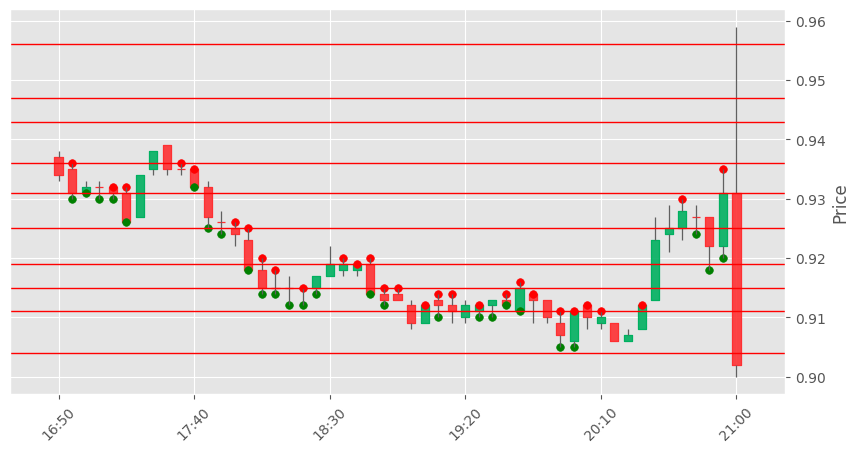

In [16]:
low_bound = 450
high_bound = 500

sup_res_sig = SignalFactory().factory('SUP_RES', configs)
levels = dfs['CRVUSDT']['5m']['levels']
level_proximity = np.mean(df['high'] - df['low']) * sup_res_sig.proximity_multiplier

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax, warn_too_much_data=10000, style='yahoo')

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()

# get signal points
for index, row in df.iterrows():
    for buy in [False, True]:
        if low_bound < index < high_bound:
            fs = sup_res_sig.check_levels(df, index, levels, level_proximity, buy)
            if fs:
                if buy:
                    scatter_candle_points_buy.append((index, df.loc[index, 'low']))
                else:
                    scatter_candle_points_sell.append((index, df.loc[index, 'high']))

for point in scatter_candle_points_buy:
    ax.scatter(point[0]-low_bound, point[1], s=30, color='green')
    
for point in scatter_candle_points_sell:
    ax.scatter(point[0]-low_bound, point[1], s=30, color='red')
    
# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax.axhline(y=level[0], color='r', linestyle='-', linewidth=1)
        
plt.show()

# Test find_lr method for LR indicator

This methods return True if price is near support level for the buy trade and near resistance level for the sell trade.

In [22]:
import pandas as pd
from talib import LINEARREG, LINEARREG_ANGLE, LINEARREG_SLOPE
timeperiod = 72

df_btc_1h = pd.read_pickle('test_ETHUSDT_1h.pkl')
df_btc_1h['linear_reg'] = LINEARREG(df_btc_1h['close'], timeperiod).reset_index(drop=True)
df_btc_1h['linear_reg_angle'] = LINEARREG_ANGLE(df_btc_1h['close'], timeperiod).reset_index(drop=True)

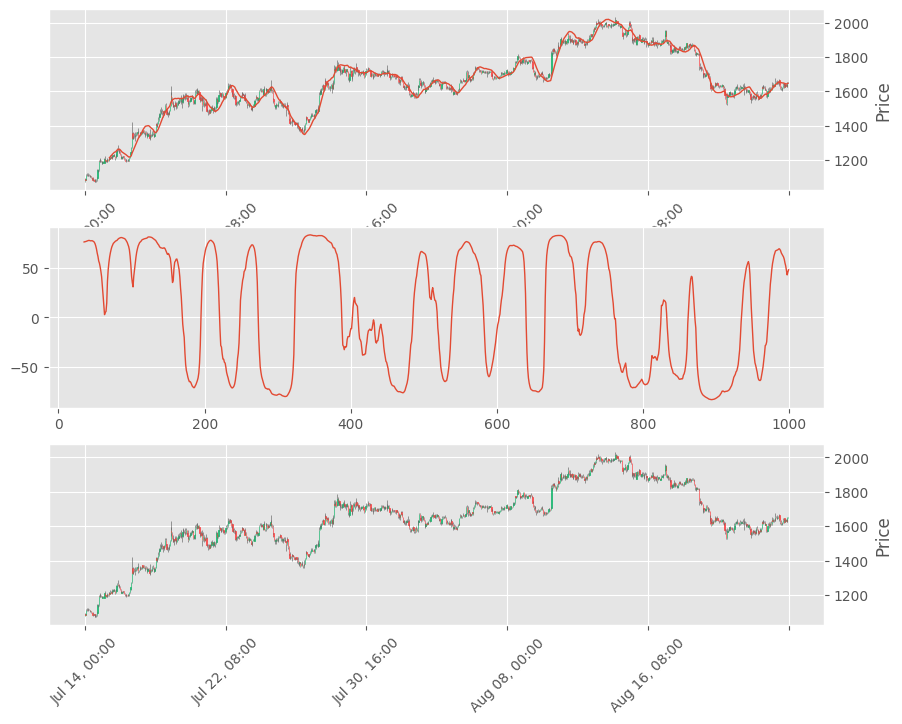

In [26]:
from talib import LINEARREG, LINEARREG_ANGLE, LINEARREG_SLOPE

low_bound = 0
high_bound = 1000
timeperiod = 36

sup_res_sig = SignalFactory().factory('SUP_RES', configs)
dfm = pd.read_pickle('test_ETHUSDT_1h.pkl')
dfh = pd.read_pickle('test_ETHUSDT_1h.pkl')

# subplots for RSI
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# plot candles
ohlch = dfh.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=axs[0], warn_too_much_data=10000, style='yahoo')

lr = LINEARREG(ohlch['close'], timeperiod).reset_index(drop=True)
lr_angle = LINEARREG_ANGLE(ohlch['close'], timeperiod).reset_index(drop=True)

axs[0].plot(lr, linewidth=1)
axs[1].plot(lr_angle, linewidth=1)

ohlcm = dfm.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlcm = ohlcm.set_index('time')
mpf.plot(ohlcm, type='candle', ax=axs[2], warn_too_much_data=10000, style='yahoo')
        
# plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI))

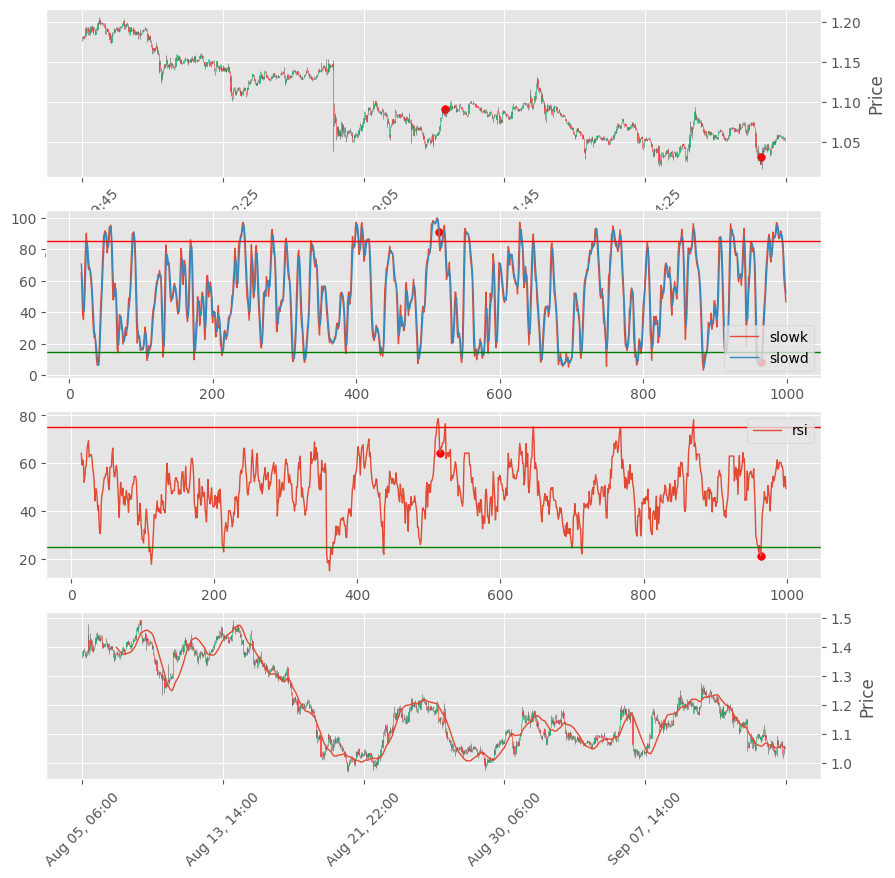

In [43]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
dfm = dfs['CRVUSDT']['5m']['data']
dfh = dfs['CRVUSDT']['1h']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(dfs, 'CRVUSDT', '5m', data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

# plot candles
ohlc = dfm.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(dfm.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(dfm.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(dfm.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

        
# plot higher timeframe candles + trend
ohlch = dfh[['time', 'open', 'high', 'low', 'close', 'volume']]
ohlch = ohlch.set_index('time')
mpf.plot(ohlch, type='candle', ax=ax4, warn_too_much_data=10000, style='yahoo')

timeperiod = 50
lr = LINEARREG(ohlch['close'], timeperiod).reset_index(drop=True)
lr_angle = LINEARREG_ANGLE(ohlch['close'], timeperiod).reset_index(drop=True)
ax4.plot(lr, linewidth=1)

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[2], dfm.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], dfm.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], dfm.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], dfm.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0], point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0], point[1], s=30, color='red')

        
plt.show()

In [42]:
points

[['CRVUSDT',
  '5m',
  515,
  'sell',
  Timestamp('2022-09-14 04:40:00'),
  [('STOCH', (15, 85)), ('RSI', (25, 75))],
  [],
  [],
  [],
  []],
 ['CRVUSDT',
  '5m',
  964,
  'buy',
  Timestamp('2022-09-15 18:05:00'),
  [('STOCH', (15, 85)), ('RSI', (25, 75))],
  [],
  [],
  [],
  []]]

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI, SUP_RES))

In [39]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI', 'SUP_RES']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

TypeError: FindSignal.find_signal() takes 5 positional arguments but 6 were given